<a href="https://colab.research.google.com/github/lhb0803/helmet-project/blob/main/colab/yolo5_finetuning_hard_helmet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set environment

In [1]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 9152, done.
remote: Total 9152 (delta 0), reused 0 (delta 0), pack-reused 9152
Receiving objects: 100% (9152/9152), 9.77 MiB | 23.21 MiB/s, done.
Resolving deltas: 100% (6348/6348), done.
/content/yolov5
     |████████████████████████████████| 636 kB 5.4 MB/s 


In [2]:
import torch
from IPython.display import Image, clear_output

clear_output()
print(f"Setup complete. Using torch {torch.__version__} \
    ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.9.0+cu102     (Tesla K80)


# 1. Inference

detect: weights=['yolov5s.pt'], source=data/images/, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False
YOLOv5 🚀 v5.0-455-g59aae85 torch 1.9.0+cu102 CUDA:0 (Tesla K80, 11441.1875MB)

100% 14.1M/14.1M [00:00<00:00, 97.1MB/s]

Fusing layers... 
Model Summary: 224 layers, 7266973 parameters, 0 gradients
image 1/2 /content/yolov5/data/images/bus.jpg: 640x480 4 persons, 1 bus, 1 fire hydrant, Done. (0.028s)
image 2/2 /content/yolov5/data/images/zidane.jpg: 384x640 2 persons, 2 ties, Done. (0.026s)
Speed: 0.5ms pre-process, 26.8ms inference, 19.7ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp


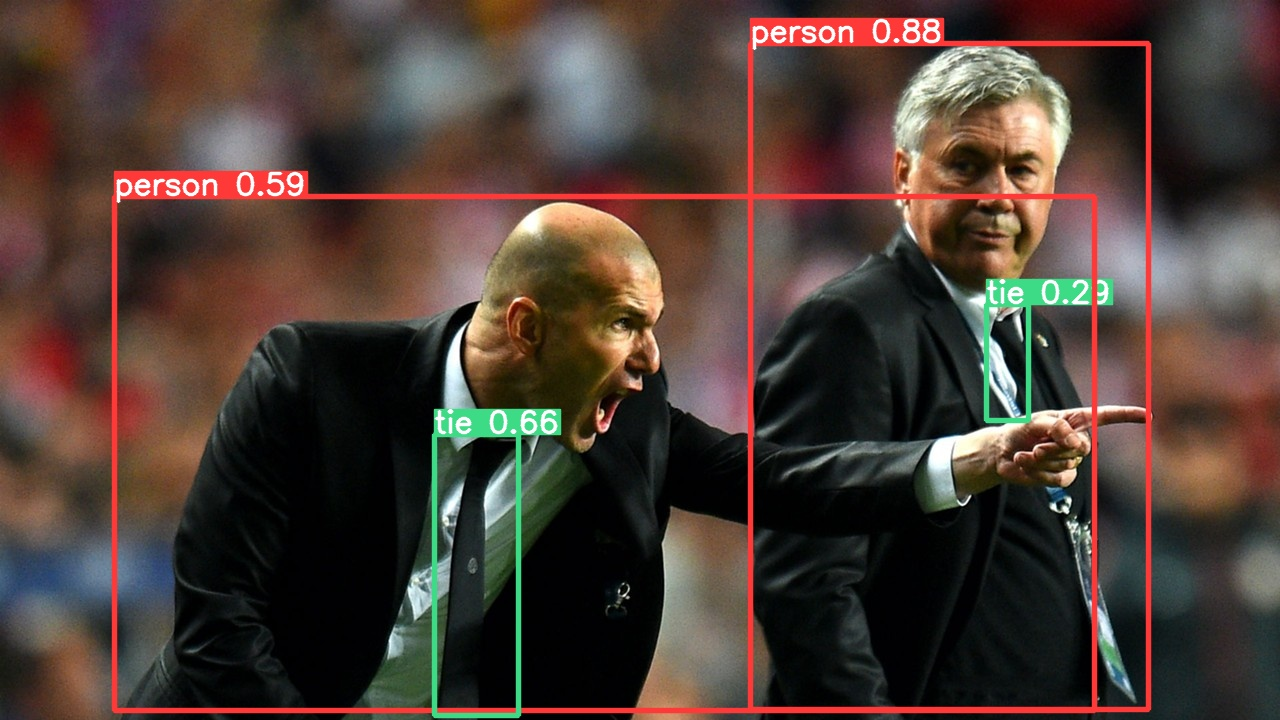

In [3]:
!python detect.py --weights yolov5s.pt --img 640 --conf 0.25 --source data/images/
Image(filename='runs/detect/exp/zidane.jpg', width=600)

# Download dataset

In [4]:
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hblee0803","key":"06058e152527d4170c3773a1c4079312"}'}

In [5]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 3.2 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=7c1e9c26691a55af2f6836014b62a0b0d056846425c8558c2f3a9d64feb72718
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [6]:
!mkdir ~/.kaggle

In [7]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle competitions list -s helmet

ref                                      deadline             category    reward  teamCount  userHasEntered  
---------------------------------------  -------------------  --------  --------  ---------  --------------  
nfl-health-and-safety-helmet-assignment  2021-11-02 23:59:00  Featured  $100,000        514           False  
nfl-impact-detection                     2021-01-04 23:59:00  Featured   $75,000        459           False  


In [9]:
!kaggle datasets list -s helmet

ref                                                                   title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
andrewmvd/hard-hat-detection                                          Safety Helmet Detection                             1GB  2020-08-11 07:40:12           3077        192  0.875            
andrewmvd/helmet-detection                                            Helmet Detection                                  391MB  2020-06-01 11:35:39           1714         50  0.875            
savanagrawal/helmet-detection-yolov3                                  Helmet Detection YOLOv3                           218MB  2020-04-02 12:10:16            823         17  1.0              
robikscube/helmet-assignment-helpers    

In [10]:
!kaggle datasets files -v andrewmvd/hard-hat-detection
!kaggle datasets download -d andrewmvd/hard-hat-detection -p ../datasets


name,size,creationDate
 99% 1.22G/1.22G [00:10<00:00, 151MB/s]
100% 1.22G/1.22G [00:10<00:00, 120MB/s]


In [11]:
!unzip -q ../datasets/hard-hat-detection.zip -d ../datasets/hard-hat-detection && rm ../datasets/hard-hat-detection.zip

# Preprocess data for YOLOv5 format

In [12]:
import os
from pathlib import Path
from xml.dom.minidom import parse
from shutil import copyfile

import numpy as np
import pandas as pd

In [13]:
classes = ['helmet','head','person']

In [14]:
def convert_annot(size , box):
    x1 = int(box[0])
    y1 = int(box[1])
    x2 = int(box[2])
    y2 = int(box[3])

    dw = np.float32(1. / int(size[0]))
    dh = np.float32(1. / int(size[1]))

    w = x2 - x1
    h = y2 - y1
    x = x1 + (w / 2)
    y = y1 + (h / 2)

    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return [x, y, w, h]

In [15]:
def save_txt_file(img_jpg_file_name, size, img_box):
    save_file_name = '../datasets/hard-hat-detection/labels/' +  img_jpg_file_name + '.txt'
    print(save_file_name)
    with open(save_file_name ,'a+') as file_path:
        for box in img_box:

            cls_num = classes.index(box[0])

            new_box = convert_annot(size, box[1:])

            file_path.write(f"{cls_num} {new_box[0]} {new_box[1]} {new_box[2]} {new_box[3]}\n")

        file_path.flush()
        file_path.close()


In [16]:
def get_xml_data(file_path, img_xml_file):
    img_path = file_path + '/' + img_xml_file + '.xml'

    dom = parse(img_path)
    root = dom.documentElement
    img_name = root.getElementsByTagName("filename")[0].childNodes[0].data
    img_size = root.getElementsByTagName("size")[0]
    objects = root.getElementsByTagName("object")
    img_w = img_size.getElementsByTagName("width")[0].childNodes[0].data
    img_h = img_size.getElementsByTagName("height")[0].childNodes[0].data
    img_c = img_size.getElementsByTagName("depth")[0].childNodes[0].data
   
    img_box = []
    for box in objects:
        cls_name = box.getElementsByTagName("name")[0].childNodes[0].data
        x1 = int(box.getElementsByTagName("xmin")[0].childNodes[0].data)
        y1 = int(box.getElementsByTagName("ymin")[0].childNodes[0].data)
        x2 = int(box.getElementsByTagName("xmax")[0].childNodes[0].data)
        y2 = int(box.getElementsByTagName("ymax")[0].childNodes[0].data)
        
        img_jpg_file_name = img_xml_file + '.jpg'
        img_box.append([cls_name, x1, y1, x2, y2])
  
    # test_dataset_box_feature(img_jpg_file_name, img_box)
    save_txt_file(img_xml_file, [img_w, img_h], img_box)

In [17]:
!mkdir ../datasets/hard-hat-detection/labels

files = os.listdir('../datasets/hard-hat-detection/annotations')
for file in files:
    print("file name: ", file)
    file_xml = file.split(".")
    print(file_xml[0])
    get_xml_data('../datasets/hard-hat-detection/annotations', file_xml[0])

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
hard_hat_workers521
../datasets/hard-hat-detection/labels/hard_hat_workers521.txt
file name:  hard_hat_workers1435.xml
hard_hat_workers1435
../datasets/hard-hat-detection/labels/hard_hat_workers1435.txt
file name:  hard_hat_workers1728.xml
hard_hat_workers1728
../datasets/hard-hat-detection/labels/hard_hat_workers1728.txt
file name:  hard_hat_workers3477.xml
hard_hat_workers3477
../datasets/hard-hat-detection/labels/hard_hat_workers3477.txt
file name:  hard_hat_workers2085.xml
hard_hat_workers2085
../datasets/hard-hat-detection/labels/hard_hat_workers2085.txt
file name:  hard_hat_workers3993.xml
hard_hat_workers3993
../datasets/hard-hat-detection/labels/hard_hat_workers3993.txt
file name:  hard_hat_workers4710.xml
hard_hat_workers4710
../datasets/hard-hat-detection/labels/hard_hat_workers4710.txt
file name:  hard_hat_workers643.xml
hard_hat_workers643
../datasets/hard-hat-detection/labels/hard_hat_workers643.txt
file name:  hard_hat_workers4916.xml
h

## Split train val test

In [18]:
from sklearn.model_selection import train_test_split

image_list = os.listdir('../datasets/hard-hat-detection/images')
train_list, test_list = train_test_split(image_list, test_size=0.1, random_state=76)
val_list, test_list = train_test_split(test_list, test_size=0.2, random_state=76)
print('total =',len(image_list))
print('train :',len(train_list))
print('val   :',len(val_list))
print('test  :',len(test_list))

total = 5000
train : 4500
val   : 400
test  : 100


In [19]:
def copy_data(file_list, img_labels_root, imgs_source, mode):

    root_file = Path('../datasets/hard-hat-detection/images/'+  mode)
    if not root_file.exists():
        print(f"Path {root_file} does not exit")
        os.makedirs(root_file)
    else: return

    root_file = Path('../datasets/hard-hat-detection/labels/' + mode)
    if not root_file.exists():
        print(f"Path {root_file} does not exit")
        os.makedirs(root_file)
    else: return

    for file in file_list:               
        img_name = file.replace('.png', '')        
        img_src_file = imgs_source + '/' + img_name + '.png'        
        label_src_file = img_labels_root + '/' + img_name + '.txt'

        # Copy image
        DICT_DIR = '../datasets/hard-hat-detection/images/' + mode
        img_dict_file = DICT_DIR + '/' + img_name + '.png'
        copyfile(img_src_file, img_dict_file)
        # Delete image
        os.remove(img_src_file)

        # Copy label
        DICT_DIR = '../datasets/hard-hat-detection/labels/' + mode
        label_dict_file = DICT_DIR + '/' + img_name + '.txt'
        copyfile(label_src_file, label_dict_file)
        # Delete image
        os.remove(label_src_file)

In [20]:
copy_data(train_list, '../datasets/hard-hat-detection/labels/', '../datasets/hard-hat-detection/images/', "train")
copy_data(val_list, '../datasets/hard-hat-detection/labels/', '../datasets/hard-hat-detection/images/', "val")
copy_data(test_list, '../datasets/hard-hat-detection/labels/', '../datasets/hard-hat-detection/images/', "test")


Path ../datasets/hard-hat-detection/images/train does not exit
Path ../datasets/hard-hat-detection/labels/train does not exit
Path ../datasets/hard-hat-detection/images/val does not exit
Path ../datasets/hard-hat-detection/labels/val does not exit
Path ../datasets/hard-hat-detection/images/test does not exit
Path ../datasets/hard-hat-detection/labels/test does not exit


## Create YAML file for dataset configuration

In [21]:
import yaml

data_config_dict = {
    'train' : '../datasets/hard-hat-detection/images/train',
    'val' : '../datasets/hard-hat-detection/images/val',
    'nc' : '3',
    'names' : ['helmet', 'head', 'person']
}

with open('./data/hard_head.yaml', 'w+') as f:
    documents = yaml.dump(data_config_dict, f)

# Train

## Set visualization setting with W&B tool

In [22]:
# Weights & Biases  (optional)
%pip install -q wandb
import wandb
# wandb.login()

     |████████████████████████████████| 1.7 MB 5.2 MB/s 
     |████████████████████████████████| 180 kB 45.3 MB/s 
     |████████████████████████████████| 97 kB 6.5 MB/s 
     |████████████████████████████████| 139 kB 43.6 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 


In [23]:
wandb.init(project='hard-helmet', entity='leeehyob', name='hemelt_project')

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Train with safety helmet data

In [24]:
!python train.py --img 416 --batch 32 --epochs 16 --data data/hard_head.yaml --cfg models/yolov5s.yaml --weights yolov5s.pt --name yolo5s_helmet

wandb: Currently logged in as: leeehyob (use `wandb login --relogin` to force relogin)
train: weights=yolov5s.pt, cfg=models/yolov5s.yaml, data=data/hard_head.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=16, batch_size=32, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, entity=None, name=yolo5s_helmet, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, upload_dataset=False, bbox_interval=-1, save_period=-1, artifact_alias=latest, local_rank=-1, freeze=0, patience=100
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v5.0-455-g59aae85 torch 1.9.0+cu102 CUDA:0 (Tesla K80, 11441.1875MB)

hyperparameters: lr0=0.01, lrf=0.2, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, ob

# Detect

In [26]:
!python detect.py --source ../datasets/hard-hat-detection/images/test  --weights runs/train/yolo5s_helmet/weights/best.pt --conf 0.25

detect: weights=['runs/train/yolo5s_helmet/weights/best.pt'], source=../datasets/hard-hat-detection/images/test, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False
YOLOv5 🚀 v5.0-455-g59aae85 torch 1.9.0+cu102 CUDA:0 (Tesla K80, 11441.1875MB)

Fusing layers... 
Model Summary: 224 layers, 7059304 parameters, 0 gradients, 16.3 GFLOPs
image 1/100 /content/datasets/hard-hat-detection/images/test/hard_hat_workers1026.png: 640x640 14 helmets, 1 head, Done. (0.032s)
image 2/100 /content/datasets/hard-hat-detection/images/test/hard_hat_workers1091.png: 640x640 17 heads, Done. (0.032s)
image 3/100 /content/datasets/hard-hat-detection/images/test/hard_hat_workers1096.png: 640x640 3 helmets, Done. (0.031s)
i

In [27]:
from IPython.display import Image
from glob import glob
import matplotlib.pyplot as plt

testfiles = glob('runs/detect/exp3/*')

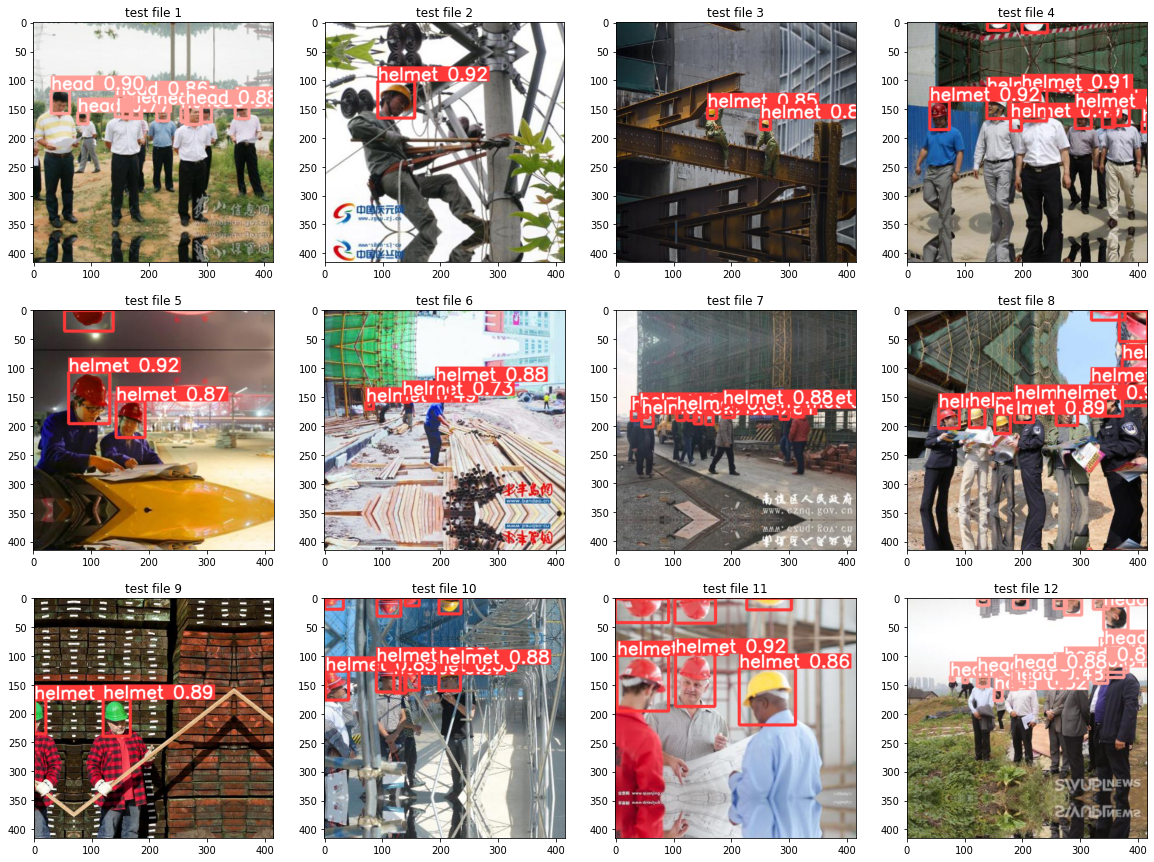

In [28]:
rows = 3
cols = 4

fig = plt.figure(figsize =(20,15))

axes = []
for i in range(rows*cols):
    img = plt.imread(testfiles[i])
    axes.append(fig.add_subplot(rows, cols, i+1))
    subplot_title=(f"test file {i+1}")
    axes[-1].set_title(subplot_title)
    plt.imshow(img)

plt.show()